<a href="https://colab.research.google.com/github/bkvkrll/PyTorch/blob/main/lesson10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/content/.config

In [17]:
! mkdir root/.kaggle

mkdir: cannot create directory ‘root/.kaggle’: No such file or directory


In [18]:
! cp kaggle.json /root/.kaggle

In [19]:
! chmod 600 /root/.kaggle/kaggle.json

In [20]:
!kaggle datasets download -d gti-upm/leapgestrecog

100% 2.13G/2.13G [00:52<00:00, 54.3MB/s]
100% 2.13G/2.13G [00:52<00:00, 43.2MB/s]


In [21]:
! unzip leapgestrecog.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapges

In [22]:
!pip install facenet-pytorch==2.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 32.3 MB/s 


In [23]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [24]:
import os
import time
import cv2 # Image handling library
import glob

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

from PIL import Image
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [26]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [27]:
def plot_model(history):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))
    epochs = len(history['epoch_losses'])
    # summarize history for accuracy
    axs[0].plot(np.arange(1, epochs + 1), history['epoch_acc'], 'c', label='Train accuracy')
    axs[0].plot(np.arange(1, epochs + 1), history['epoch_val_acc'], 'm', label='Test accuracy')
    axs[0].set_title('Accuracy of epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].legend(loc='lower right')
    axs[0].grid(color='lightgrey')
    # summarize history for loss
    axs[1].plot(np.arange(1, epochs + 1), history['epoch_losses'], 'c', label='Train loss')
    axs[1].plot(np.arange(1, epochs + 1), history['epoch_val_losses'], 'm', label='Test loss')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].grid(color='lightgrey')
    plt.show()

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
dst_path = '/content/leapGestRecog'

In [30]:
CATEGORIES = ['01_palm', '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']

In [31]:
# Модуль glob находит все пути, совпадающие с заданным шаблоном в соответствии с правилами. 
# glob.glob(pathname) возвращение список (возможно, пустой) путей, соответствующих шаблону pathname.
images = glob.glob('/content/leapGestRecog/**/**/*.png')

# extract label number from filename and reduce by 1 so that it ranges from 0 to 9 (instead of 1 to 10). Otherwise loss function will complain
label = [int(os.path.basename(i).split('_')[2])-1 for i in images]

In [32]:
train_transformer = transforms.Compose([
                    transforms.Resize((48, 128)),                # resize the image to 64x64 
                    transforms.RandomHorizontalFlip(),           # randomly flip image horizontally
                    transforms.ToTensor()])                      # transform it into a PyTorch Tensor

test_transformer = transforms.Compose([
                   transforms.Resize((48, 128)),                 # resize the image to 64x64 
                   transforms.Grayscale(num_output_channels=1),  # returned image is single channel
                   transforms.ToTensor()])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(images, label, test_size = 0.3, random_state=42)

In [34]:
class SIGNSDataset(Dataset):
    def __init__(self, filenames, labels, transform):      
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [35]:
train_dataset = SIGNSDataset(X_train, y_train, train_transformer)
test_dataset = SIGNSDataset(X_test, y_test, test_transformer)

In [36]:
batch_size = 32
lr = 0.01
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size)

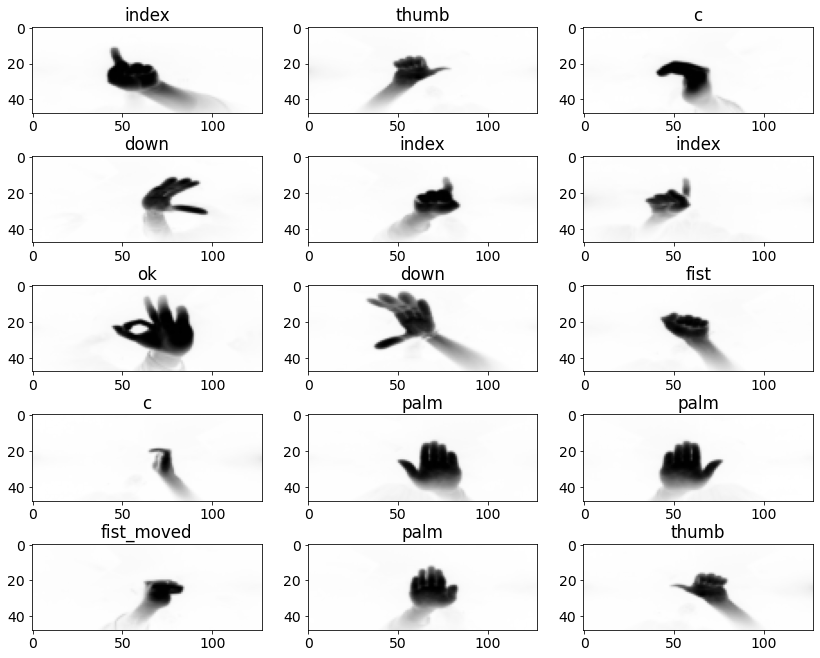

In [37]:
data_iter = iter(train_dl)

img, labels = data_iter.next()

plt.figure(figsize=(14, 21))
for i in range(batch_size):
    ax = plt.subplot(9, 3, i+1)
    plt.imshow(img[i, 0, :, :], cmap='Greys')
    plt.title(f'{CATEGORIES[int(labels[i])][3:]}')
    if i > 13:
        break

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.3)
        self.fc1 = nn.Linear(32*22*62, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [39]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [40]:
epochs = 20

In [41]:
total_steps = len(train_dl)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

20 epochs, 438 total_steps per epoch


In [42]:
def fit(model, epochs):
    
    epoch_losses = []
    epoch_acc = []
    epoch_val_losses = []
    epoch_val_acc = []
    bundle = 20

    
    # Print model's state_dict        
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print('\t', param_tensor,': ', model.state_dict()[param_tensor].size())

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        cum_loss = []
        cum_acc = []

        # print(f'Epochs: {epoch+1}')
        time1 = time.time()
        model.train()
        for i, data in enumerate(train_dl, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            cum_loss.append(loss.item())

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            cum_acc.append(correct / total)

        time2 = time.time()
        epoch_losses.append(np.mean(cum_loss))
        epoch_acc.append(np.mean(cum_acc))

        cum_loss = []
        cum_acc = []
        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for i, data in enumerate(test_dl, 0):
                inputs, labels = data
                inputs = inputs.to(device) 
                labels = labels.to(device) 

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                cum_loss.append(loss.item())

                # Отслеживание точности
                total = labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct = (predicted == labels).sum().item()
                cum_acc.append(correct / total)

        epoch_val_losses.append(np.mean(cum_loss))
        epoch_val_acc.append(np.mean(cum_acc))
        print(f'Epochs: {epoch+1}   loss: {epoch_losses[-1]:.5f}   '
              f'accuracy: {epoch_acc[-1]*100:.3f}%   '
              f'loss_val: {epoch_val_losses[-1]:.5f}   '
              f'accuracy_val: {epoch_val_acc[-1]*100:.3f}%   '
              f'time = {time2-time1:.2f} s')
        
    return {'epoch_losses': epoch_losses, 
            'epoch_val_losses': epoch_val_losses, 
            'epoch_acc': epoch_acc, 
            'epoch_val_acc': epoch_val_acc}

In [43]:
history = fit(model, epochs)

Model's state_dict:
	 conv1.weight :  torch.Size([32, 1, 3, 3])
	 conv1.bias :  torch.Size([32])
	 conv2.weight :  torch.Size([32, 32, 3, 3])
	 conv2.bias :  torch.Size([32])
	 fc1.weight :  torch.Size([128, 43648])
	 fc1.bias :  torch.Size([128])
	 fc2.weight :  torch.Size([10, 128])
	 fc2.bias :  torch.Size([10])
Epochs: 1   loss: 1.88760   accuracy: 34.154%   loss_val: 1.47177   accuracy_val: 48.388%   time = 40.47 s
Epochs: 2   loss: 0.78566   accuracy: 73.994%   loss_val: 0.38638   accuracy_val: 88.065%   time = 33.60 s
Epochs: 3   loss: 0.31200   accuracy: 89.940%   loss_val: 0.24530   accuracy_val: 92.670%   time = 32.78 s
Epochs: 4   loss: 0.16510   accuracy: 95.362%   loss_val: 0.06045   accuracy_val: 98.238%   time = 32.97 s
Epochs: 5   loss: 0.11317   accuracy: 96.953%   loss_val: 0.07247   accuracy_val: 97.590%   time = 32.67 s
Epochs: 6   loss: 0.07303   accuracy: 97.931%   loss_val: 0.03026   accuracy_val: 99.136%   time = 32.67 s
Epochs: 7   loss: 0.06173   accuracy: 98.

In [44]:
torch.save(model.state_dict(), '/content/leapGestRecog/hand_gesture_recognitionemotion')

In [45]:
net = Net().to(device)
net.load_state_dict(torch.load('/content/leapGestRecog/hand_gesture_recognitionemotion', map_location=torch.device('cpu')))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=43648, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

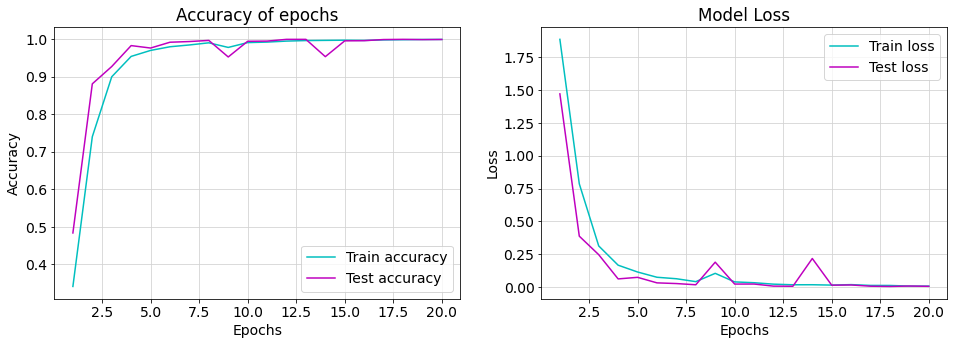

In [46]:
plot_model(history)

correct: 32 / 32


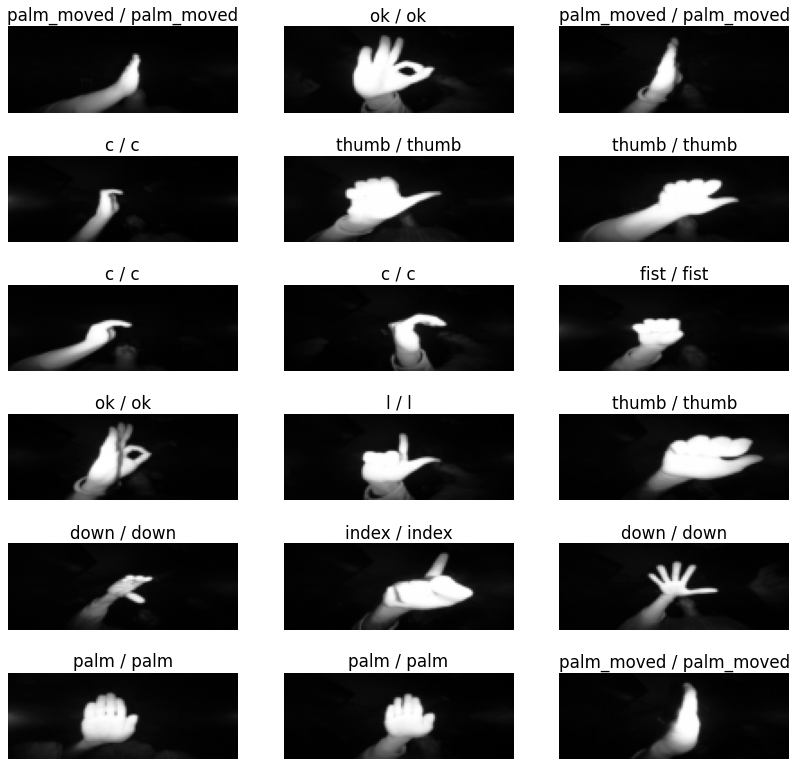

In [47]:
data_iter = iter(test_dl)

img, labels = data_iter.next()

# print(f'labels: {labels}')

model.eval()
with torch.no_grad():
    inputs = img.to(device)
    labels = labels.to(device)

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    # Отслеживание точности
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
#     print(f'predicted: {predicted}')
    correct = (predicted == labels).sum().item()
    print(f'correct: {batch_size} / {correct}')

plt.figure(figsize=(14, 21))
for i in range(batch_size):
    ax = plt.subplot(9, 3, i+1)
    
    plt.imshow(img[i, 0, :, :], cmap='Greys_r')
    if int(labels[i]) == int(predicted[i]):
        plt.title(f'{CATEGORIES[int(labels[i])][3:]} / {CATEGORIES[int(predicted[i])][3:]}')
    else:
        plt.title(f'Error: {CATEGORIES[int(labels[i])][3:]} / {CATEGORIES[int(predicted[i])][3:]}')
    plt.axis('off')
    if i > 16:
        break